In [124]:
import torch
from torch import nn, optim
import numpy as np
import hamiltorch
from qmc.local_energy import auto_hamiltonian_generator_atoms
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [13]:
from qmc.mcmc import metropolis_symmetric, metropolis_asymmetric,unadjusted_langevin, normal_proposal, clip_normal_proposal, NormalProposal, ClipNormalProposal
from qmc.wavefunction import HarmonicTrialFunction, HydrogenTrialWavefunction, HeliumTrialWavefunction, NelectronVander

In [14]:
class HeliumVanderSum(nn.Module):
    #ansatz given by the sum of the Vandermonde determinants of the one electron wavefunctions e^(-alpha_1*r_i) and e^(-alpha_2*r_i)
    #input is 2-element tensor alpha 
    def __init__(self, alpha):
        super(HeliumVanderSum, self).__init__()
        self.alpha = nn.Parameter(alpha)
            
    def forward(self, x):
        #returns the log prob. of the wavefunction
        #input is tensor of size m x alpha.size or m x n x alpha.size
        a = torch.exp(-self.alpha[0]*x.unsqueeze(-1)) - torch.exp(-self.alpha[0]*x.unsqueeze(-2))
        V1 = torch.prod(a[...,torch.triu(torch.ones(3,3), diagonal=1).nonzero(as_tuple = True)[0],torch.triu(torch.ones(3,3), diagonal=1).nonzero(as_tuple = True)[1] ],-1)
        b = torch.exp(-self.alpha[1]*x.unsqueeze(-1)) - torch.exp(-self.alpha[1]*x.unsqueeze(-2))
        V2 = torch.prod(b[...,torch.triu(torch.ones(3,3), diagonal=1).nonzero(as_tuple = True)[0],torch.triu(torch.ones(3,3), diagonal=1).nonzero(as_tuple = True)[1] ],-1)
        #c = torch.exp(-self.alpha[2]*x.unsqueeze(-1)) - torch.exp(-self.alpha[2]*x.unsqueeze(-2))
        #V3 = torch.prod(c[...,torch.triu(torch.ones(3,3), diagonal=1).nonzero(as_tuple = True)[0],torch.triu(torch.ones(3,3), diagonal=1).nonzero(as_tuple = True)[1] ],-1)
        return 2 * torch.log(torch.abs(V1+V2))
    
    def wave(self,x):
        # Returns the value of the wavefunction
        #input is tensor of size m x alpha.size or m x n x alpha.size
        a = torch.exp(-self.alpha[0]*x.unsqueeze(-1)) - torch.exp(-self.alpha[0]*x.unsqueeze(-2))
        V1 = torch.prod(a[...,torch.triu(torch.ones(3,3), diagonal=1).nonzero(as_tuple = True)[0],torch.triu(torch.ones(3,3), diagonal=1).nonzero(as_tuple = True)[1] ],-1)
        b = torch.exp(-self.alpha[1]*x.unsqueeze(-1)) - torch.exp(-self.alpha[1]*x.unsqueeze(-2))
        V2 = torch.prod(b[...,torch.triu(torch.ones(3,3), diagonal=1).nonzero(as_tuple = True)[0],torch.triu(torch.ones(3,3), diagonal=1).nonzero(as_tuple = True)[1] ],-1)
        #c = torch.exp(-self.alpha[2]*x.unsqueeze(-1)) - torch.exp(-self.alpha[2]*x.unsqueeze(-2))
        #V3 = torch.prod(c[...,torch.triu(torch.ones(3,3), diagonal=1).nonzero(as_tuple = True)[0],torch.triu(torch.ones(3,3), diagonal=1).nonzero(as_tuple = True)[1] ],-1)
        return (V1+V2)
    
    def local_energy(self, x):
        return auto_hamiltonian_generator_atoms(self, 2, x) / self.wave(x)

In [212]:
tf = HeliumVanderSum(torch.rand(2))

In [213]:
n_walkers=10
init_config = torch.rand(n_walkers,3)

In [214]:
results = metropolis_symmetric(tf, init_config, ClipNormalProposal(.5, min_val=0.1), num_walkers=n_walkers, num_steps=10000)

In [215]:
print(torch.mean(tf.local_energy(results)))

tensor(-4.8223, grad_fn=<MeanBackward0>)


In [186]:
def energy_minimize_step(trialfunc, samples, optimizer):
    local_energies = trialfunc.local_energy(samples).detach()
    mean_local_energy = local_energies.mean()
    print('energy is', mean_local_energy)
    sample_logprobs = trialfunc(samples)
    loss = ((local_energies - mean_local_energy) * sample_logprobs).mean()
    optimizer.zero_grad()
    loss.backward()
    print('grad is', trialfunc.alpha.grad)
    optimizer.step()

In [207]:
def vmc_iterate(tf, init_config, num_iters=100):
    opt = optim.SGD(tf.parameters(), lr=5e-2,momentum=0.01)
    # propdist = NormalProposal(0.3)
    #propdist = ClipNormalProposal(sigma=0.001, min_val=0.1)
    propdist = ClipNormalProposal(.5, min_val=0.1)
    for i in range(num_iters):
        results=metropolis_symmetric(tf, init_config, propdist, num_walkers=10, num_steps=5000)
        energy_minimize_step(tf, results, opt)
        print(tf.alpha)

In [195]:
tf = HeliumVanderSum(torch.rand(2))
init_config = torch.rand(n_walkers,3)
vmc_iterate(tf, init_config)

energy is tensor(-4.4162)
grad is tensor([0.2150, 0.9075])
Parameter containing:
tensor([0.2576, 0.5241], requires_grad=True)
energy is tensor(-4.4816)
grad is tensor([-0.2458,  0.7544])
Parameter containing:
tensor([0.2698, 0.4859], requires_grad=True)
energy is tensor(-5.0198)
grad is tensor([-0.9225,  0.7815])
Parameter containing:
tensor([0.3161, 0.4465], requires_grad=True)
energy is tensor(-4.5126)
grad is tensor([-1.2239,  0.4502])
Parameter containing:
tensor([0.3777, 0.4236], requires_grad=True)
energy is tensor(-5.0631)
grad is tensor([0.0990, 0.0913])
Parameter containing:
tensor([0.3734, 0.4188], requires_grad=True)
energy is tensor(-4.6390)
grad is tensor([0.4842, 0.6178])
Parameter containing:
tensor([0.3491, 0.3878], requires_grad=True)
energy is tensor(-5.4110)
grad is tensor([0.0032, 0.1854])
Parameter containing:
tensor([0.3487, 0.3783], requires_grad=True)
energy is tensor(-5.3655)
grad is tensor([0.3816, 0.5630])
Parameter containing:
tensor([0.3297, 0.3500], requir

KeyboardInterrupt: 

In [199]:
def alpha_values():
    means = []
    val1 = []
    val2 = []
    x = torch.linspace(0,1,20)
    y = torch.linspace(0,1,20)
    propdist = ClipNormalProposal(.5, min_val=0.1)
    for i in range(20):
        for j in range(20):
            if(x[i] != 0 and y[j] != 0):
                print(x[i],y[j])
                tf = HeliumVanderSum(torch.stack((x[i],y[j]),dim=0))
                init_config = torch.rand(n_walkers,3)
                samples = metropolis_symmetric(tf, init_config, propdist, num_walkers=n_walkers, num_steps=5000)
                means.append(torch.mean(tf.local_energy(samples)).item())
                val1.append(x[i].item())
                val2.append(y[j].item())
                print(means[-1])
    return val1, val2, means

In [200]:
val1, val2, means = alpha_values()

tensor(0.0526) tensor(0.0526)
-2.5790278911590576
tensor(0.0526) tensor(0.1053)


KeyboardInterrupt: 

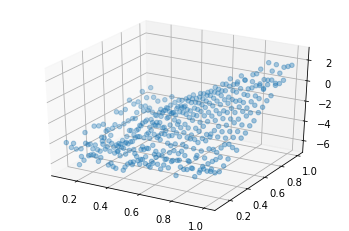

In [152]:
%matplotlib inline
ax = plt.axes(projection='3d')
ax.set(zlim=(-7, 3))
ax.scatter3D(val1, val2, means, cmap='Greens');

In [217]:
def alpha_value():
    means = []
    vals = []
    x = torch.linspace(-.03,.8,30)
    propdist = ClipNormalProposal(.5, min_val=0.1)
    for i in range(30):
        if(x[i] != 0):
            print(x[i])
            tf = HeliumVanderSum(torch.stack((x[i],x[i]),dim=0))
            init_config = torch.rand(n_walkers,3)
            samples = metropolis_symmetric(tf, init_config, propdist, num_walkers=n_walkers, num_steps=5000)
            means.append(torch.mean(tf.local_energy(samples)).item())
            vals.append(x[i].item())
            print(means[-1])
    return vals, means

In [218]:
vals, means = alpha_value()

tensor(-0.0300)
-0.787937343120575
tensor(-0.0014)
-2.1224379539489746
tensor(0.0272)
-2.9186959266662598
tensor(0.0559)
-3.1226558685302734
tensor(0.0845)
-4.519529819488525
tensor(0.1131)
-2.988431930541992
tensor(0.1417)
-5.960390090942383
tensor(0.1703)
-5.50349235534668
tensor(0.1990)
-5.500298976898193
tensor(0.2276)
-5.139177322387695
tensor(0.2562)
-5.632708549499512
tensor(0.2848)
-5.74395751953125
tensor(0.3134)
-5.814207077026367
tensor(0.3421)
-4.975887298583984
tensor(0.3707)
-4.882338047027588
tensor(0.3993)
-5.546814441680908
tensor(0.4279)
-4.498619556427002
tensor(0.4566)
-4.861379146575928
tensor(0.4852)
-4.2987189292907715
tensor(0.5138)
-3.718737840652466
tensor(0.5424)
-3.397075891494751
tensor(0.5710)
-3.1670100688934326
tensor(0.5997)
-3.1010663509368896
tensor(0.6283)
-2.50930118560791
tensor(0.6569)
-2.315452814102173
tensor(0.6855)
-1.971093773841858
tensor(0.7141)
-1.6761785745620728
tensor(0.7428)
-1.3329540491104126
tensor(0.7714)
-1.1533783674240112
tensor